<a href="https://colab.research.google.com/github/MarcoBarroca/VI_EAFEXP_Proj3/blob/main/projetos/Rafael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import pandas as pd
  
# read the dataset using the compression zip
lightcurves_train = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_train_lightcurves.csv.gz',compression='gzip')
metadata_train = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_train_metadata.csv.gz',compression='gzip')
metadata_test = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_test_metadata.csv.gz',compression='gzip')
lightcurves_extra = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_lightcurves_extra.csv.gz',compression='gzip')

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from tqdm import tqdm, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

##Sorteia e plota uma curva de luz

<ipython-input-146-a2f9e80e40eb>:11: MatplotlibDeprecationWarning: Saw kwargs ['mfc', 'markerfacecolor'] which are all aliases for 'markerfacecolor'.  Kept value from 'markerfacecolor'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.plot(x,y, '.', linestyle='solid',  mfc='none', mec='b', markersize=24, markerfacecolor='white')


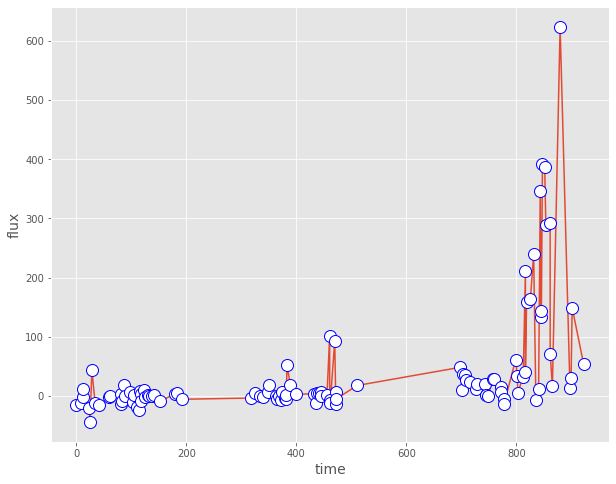

In [146]:
x = np.random.choice(metadata_train['object_id'],1)

id = lightcurves_train[np.array(lightcurves_train['object_id']) == x]

x = np.array(id['mjd'])
y = np.array(id['flux'])
x=x-np.min(x)
plt.figure(figsize=(10,8))
plt.xlabel('time', fontsize=14)
plt.ylabel('flux', fontsize=14)
plt.plot(x,y, '.', linestyle='solid',  mfc='none', mec='b', markersize=24, markerfacecolor='white')

#converter a unidade de tempo 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

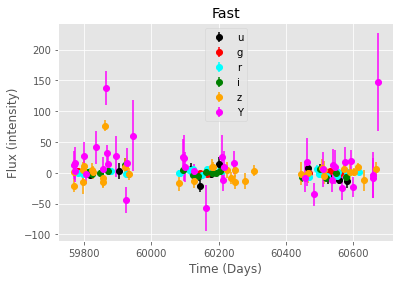

<Figure size 432x288 with 0 Axes>

In [194]:

mg_df = lightcurves_train.merge(metadata_train[['object_id', 'target']], how= 'inner', on = 'object_id')
#print(mg_df)
#data_df = mg_df.merge(metadata_train[['object_id', 'passband']], how= 'inner', on = 'object_id')

z = 64
name = 'Fast'


x = mg_df.query('target == {}'.format(z)).sample(1)['object_id'].values
id = lightcurves_train[np.array(lightcurves_train['object_id']) == x]







plt.figure()
lc_data = id[['mjd', 'flux', 'flux_err', 'passband']].values
colors = ['k', 'r', 'cyan', 'g', 'orange', 'magenta']
bands = 'ugrizY'


fig, ax1 = plt.subplots()

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='Flux (intensity)',
    xlabel='Time (Days)',
)
handles, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.4,0.3))




for i in range(6):
  mask = lc_data[:,3] == i
  lc_band = lc_data[mask]
  plt.errorbar(lc_band[:,0], lc_band[:,1], yerr=lc_band[:,2], marker='o', ls='', color=colors[i], label=bands[i])

plt.title('{}'.format(name))
plt.legend(loc='best')








plt.figure()



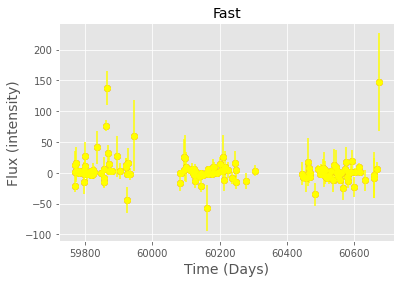

In [195]:
id = lightcurves_train[np.array(lightcurves_train['object_id']) == x]


fig, ax1 = plt.subplots()

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='Flux',
    xlabel='Mjd',
)

plt.title('{}'.format(name))
x = np.array(id['mjd'])
y = np.array(id['flux'])
yerr = np.array(id['flux_err'])
plt.xlabel('Time (Days)', fontsize=14)
plt.ylabel('Flux (intensity)', fontsize=14)

plt.errorbar(x,y,yerr=yerr, marker='o', ls='',color='yellow', label=bands[i])
plt.plot(x,y, '.',  marker='o')


In [165]:
mg_df.query('target == 16').sample(1)['object_id'].values




array([38054020])

## super classes

In [122]:
classes = metadata_train["target"].value_counts().rename_axis('unique_values').reset_index(name='counts').sort_values(by='unique_values')

my_dict={42: 0,
 52: 0,
 62: 0,
 67: 0,
 90: 0,
 6: 1,
 64: 1,
 65: 1,
 15: 2,
 95: 2,
 16: 3,
 53: 3,
 92: 3,
 88:4
}


class_names={
    6: 'Single micro-lens',
    15: 'TDE',
    16: 'Eclipsing Binary ',
    42: 'SNII ',
    52: 'SNIax',
    53: 'Mira',
    62: 'SNIbc',
    64: 'Kilonova',
    65: 'M-dwarf',
    67: 'SNIa-91bg',
    88: 'AGN ',
    90: 'SNIa',
    92: 'RR lyrae',
    95: 'SLSN-I',
}

gen_class={0: 'S-like',
 1: 'Fast',
 2: 'Long',
 3: 'Periodic',
 4: 'Non-periodic'
} 

classes['Class Name']=classes['unique_values'].map(class_names)
classes['General Class']=classes['unique_values'].map(my_dict)
classes['General Class Name']=classes['General Class'].map(gen_class)
classes = classes.rename(columns={'unique_values':'Class'},inplace=False)


print('')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

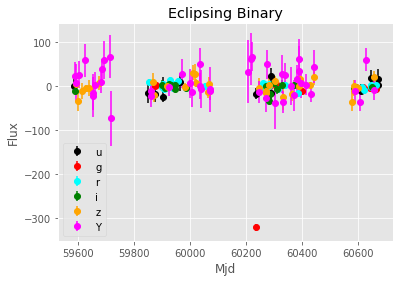

<Figure size 432x288 with 0 Axes>

In [123]:

mg_df = lightcurves_train.merge(metadata_train[['object_id', 'target']], how= 'inner', on = 'object_id')
#print(mg_df)
#data_df = mg_df.merge(metadata_train[['object_id', 'passband']], how= 'inner', on = 'object_id')

z = 16
name = 'Eclipsing Binary'


x = mg_df.query('target == {}'.format(z)).sample(1)['object_id'].values
id = lightcurves_train[np.array(lightcurves_train['object_id']) == x]







plt.figure()
lc_data = id[['mjd', 'flux', 'flux_err', 'passband']].values
colors = ['k', 'r', 'cyan', 'g', 'orange', 'magenta']
bands = 'ugrizY'


fig, ax1 = plt.subplots()

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='Flux',
    xlabel='Mjd',
)
handles, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.4,0.3))




for i in range(6):
  mask = lc_data[:,3] == i
  lc_band = lc_data[mask]
  plt.errorbar(lc_band[:,0], lc_band[:,1], yerr=lc_band[:,2], marker='o', ls='', color=colors[i], label=bands[i])

plt.title('{}'.format(name))
plt.legend(loc='best')








plt.figure()



In [ ]:
id = lightcurves_train[np.array(lightcurves_train['object_id']) == x]


fig, ax1 = plt.subplots()

ax1.set(
    axisbelow=True,  # Hide the grid behind plot objects
    ylabel='Flux',
    xlabel='Mjd',
)

plt.title('{}'.format(name))
x = np.array(id['mjd'])
y = np.array(id['flux'])
yerr = np.array(id['flux_err'])
plt.xlabel('Time', fontsize=14)
plt.ylabel('Flux', fontsize=14)
plt.errorbar(x,y,yerr=yerr, marker='o', ls='', color=colors[i], label=bands[i])
plt.plot(x,y, '.',  marker='o', color = 'blue')


<ipython-input-121-4d788d99b730>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  id = lightcurves_train[np.array(lightcurves_train['object_id']) == x]


KeyError: ignored

##Distribuição das clases por quantidade de aparição


    unique_values  counts
11              6     151
4              15     495
3              16     924
1              42    1193
9              52     183
13             53      30
5              62     484
12             64     102
2              65     981
8              67     208
6              88     370
0              90    2313
7              92     239
10             95     175


Text(0, 0.5, 'count')

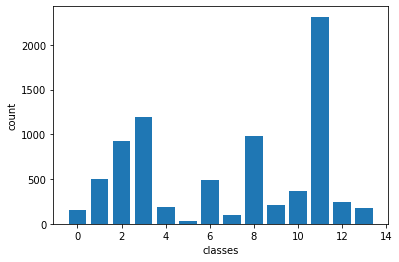

In [ ]:
classes = metadata_train["target"].value_counts().rename_axis('unique_values').reset_index(name='counts').sort_values(by='unique_values')
counts=[]

print(classes)
plt.bar(range(len(classes['unique_values'])),classes['counts'])
plt.xlabel('classes')
plt.ylabel('count')

#remover objetos vasios

##Distribuição de filtros por por quantidade de aparição

      unique_values  counts
0               615     352
1279            713     350
1610            730     330
907             745     351
513            1124     352
...             ...     ...
2593      130739978     147
6789      130755807     114
4341      130762946     134
2867      130772921     144
6313      130779836     118

[7848 rows x 2 columns]


1421705

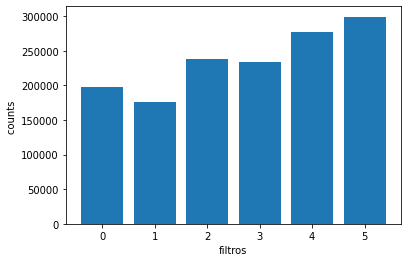

In [ ]:
filtros = lightcurves_train["passband"].value_counts().rename_axis('unique_values').reset_index(name='counts').sort_values(by='unique_values')
objetos = metadata_test["object_id"].value_counts().rename_axis('unique_values').reset_index(name='counts').sort_values(by='unique_values')
counts=[]

print(objetos)
plt.bar(range(len(filtros['unique_values'])),filtros['counts'])
plt.xlabel('filtros')
plt.ylabel('counts ')

sum(filtros['counts'])


In [ ]:
filtro_1 = 0
filtro_2 = 0
filtro_3 = 0
filtro_4 = 0
filtro_5 = 0
filtro_6 = 0


for x in lightcurves_train['passband']:
  if x['passband'] == 1:
    filtro_1+=1
  if int(x['passband']) == 2:
    filtro_2+=1
  if int(x['passband']) == 3:
    filtro_3+=1
  if int(x['passband']) == 4:
    filtro_4+=1
  if int(x['passband']) == 5:
    filtro_5+=1
  if int(x['passband']) == 6:
    filtro_6+=1



print(filtro_1)
'''
plt.bar(range(len(filtros['unique_values'])),filtros['counts'])
plt.xlabel('filtros')
plt.ylabel('counts ')

sum(filtros['counts'])'''


TypeError: ignored

      unique_values  counts
0               615     352
1            173059     352
2            167417     352
3            167436     352
4            167488     352
...             ...     ...
7843      100413487      55
7844       68643457      52
7845      119353712      52
7846       86237249      50
7847       49575267      47

[7848 rows x 2 columns]


Text(0, 0.5, 'counts')

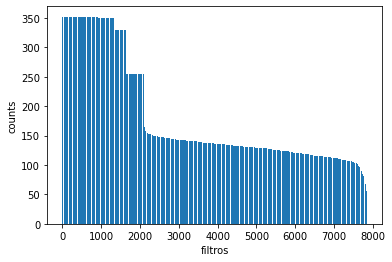

In [ ]:
pontos = lightcurves_train["object_id"].value_counts().rename_axis('unique_values').reset_index(name='counts')

counts=[]

print(pontos)
plt.bar(range(len(pontos['unique_values'])),pontos['counts'])
plt.xlabel('filtros')
plt.ylabel('counts')

#remover objetos vazios

In [ ]:
print(max(pontos["counts"]))
print(min(pontos["counts"]))

352
47


##distribuição dos fluxos

In [ ]:
flux = lightcurves_train["flux"].value_counts().rename_axis('unique_values').reset_index(name='counts')



print(flux)
plt.bar(range(len(flux['unique_values'])),flux['counts'])
plt.xlabel('filtros')
plt.ylabel('counts')

         unique_values  counts
0             0.670238       5
1            -0.289681       4
2            -0.332783       4
3             0.258622       4
4             0.421939       4
...                ...     ...
1387852      -2.651241       1
1387853       3.065438       1
1387854      -4.842262       1
1387855      -1.341718       1
1387856     -41.214264       1

[1387857 rows x 2 columns]


##modelo para codigos de teste

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))

model.add(Dense(1), activation='Softmax')
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics = ['accuracy'])
# fit model


EPOCHS = 200
BATCH_SIZE = 32

history = network.fit(x=norm_x_train, 
                      y=y_train,
                        validation_data=(norm_x_val, y_val),
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE)

In [ ]:


model = Sequential()

model.add(LSTM(128, activation='relu',
               input_shape=(1000, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

##modelo usado pelo marco

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre
import tensorflow as tf
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Masking, LSTM
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K



##versão marco


In [ ]:
def normalize_table(tab):
  f_scaler=pre.MinMaxScaler(feature_range=(-1,1)).fit(tab[:,1:3])
  tab[:,1:3]=f_scaler.transform(tab[:,1:3])
  tab[:,0]=tab[:,0]-np.min(tab[:,0])

  return tab

In [ ]:
obj_ids = metadata_train['object_id']
tables=[]


for i in range(len(obj_ids)):
  lines=lightcurves_train[lightcurves_train['object_id']==obj_ids[i]]
  flux=np.array(lines['flux'])
  error=np.array(lines['flux_err'])
  mjd=np.array(lines['mjd'])
  filter=np.array(lines['passband'])
  table=np.array([mjd,flux,error,filter],dtype=np.float32).T
  table=normalize_table(table)
  tables.append(table)

tables=tf.keras.preprocessing.sequence.pad_sequences(tables,value=-99 ,maxlen=352, padding='post')


print(flux)
np_tables=np.array(tables)

[ 5.71036438e+02  7.49963562e+02  8.11698425e+02  7.91284973e+02
  8.34375305e+02  7.59056091e+02  2.14849390e+03  2.28512256e+03
  2.47102197e+03  2.61835791e+03  2.26977856e+03  4.46383203e+03
  4.96022266e+03  4.97290186e+03  4.99514404e+03  4.53169189e+03
  4.90862451e+03  3.08828394e+03  5.03067139e+03  3.32093628e+03
  1.03660071e+03  1.08198230e+03  1.21493486e+04  1.00438887e+04
  1.63663906e+04  2.73438184e+04  2.90582129e+04  3.14370898e+04
  5.49828750e+04  7.76132178e+03  3.04264795e+03  2.32277393e+03
  2.26248633e+03  1.99136682e+03  1.49787781e+03  1.64921436e+03
  8.48485596e+02  1.47504224e+03  1.24245044e+03  1.10311218e+03
  1.28821643e+03  1.21118420e+03  1.24417993e+03  8.60472778e+02
  8.39401184e+02  1.29561722e+02  4.41659821e+02  6.69308594e+02
  6.85887634e+02  3.98940002e+02  7.35358200e+01  3.48590912e+02
  3.68633392e+02  3.94234711e+02  3.04545258e+02  3.05615570e+02
  2.70237976e+02  9.07141110e+01  2.76659332e+02  1.00993713e+02
  1.95757477e+02  2.01932

##minha versão

In [ ]:
lightcurves_train

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421700,130779836,60555.9838,4,-39.881969,46.477093,0
1421701,130779836,60560.0459,1,14.894439,18.947685,0
1421702,130779836,60571.0225,5,30.593130,50.695290,0
1421703,130779836,60585.9974,4,-23.471439,44.819859,0


In [ ]:
metadata_train

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.7188,-14.9403,0,0.000,0.000,0.000,-9.000,0.013,65,...,0.0,0.0,59570.000,18232,26.4,267.6,742.8,3295.1,6047.5,7955.2
7844,130755807,120.1013,-62.6967,0,0.172,2.561,1.115,46.611,0.136,90,...,0.0,0.0,60056.809,14934,0.0,0.0,0.0,0.0,0.0,0.0
7845,130762946,203.1081,-55.6821,0,0.000,0.000,0.000,-9.000,0.430,16,...,0.0,0.0,59570.000,47805,83.8,1124.7,1445.1,1191.2,848.9,382.5
7846,130772921,79.1016,-35.5018,0,0.000,0.000,0.000,-9.000,0.034,65,...,0.0,0.0,59570.000,22240,1.9,14.4,49.4,244.3,534.8,897.2


In [ ]:
train_x = []
value_x = []

train_y = []
value_y = []

mjd = np.array(lightcurves_train['mjd'])
fluxo = np.array(lightcurves_train['flux'])
err_flux = np.array(lightcurves_train['flux_err'])
filtro = np.array(lightcurves_train['passband'])

fluxo = (fluxo - fluxo.min()) / (fluxo.max() - fluxo.min())

teste = [mjd, fluxo,err_flux,filtro]

y = metadata_train['target']
y = pre.LabelBinarizer().fit_transform(y)


# inicializa um array de indices, correspondente ao indices dos dados aleatorizados 
all_index = range(len(filtro))
#random_index = np.random.choice(all_index, len(all_index), replace=False) aleatorizar os dados

# escolhendo ~80% dos dados para treino e ~20% pra teste
train_len = int(0.8*len(filtro))

print(train_len)

for x in teste:
  train_index = x[:train_len]
  val_size = x[train_len:]
  train_x.append(train_index)
  value_x.append(val_size)



# inicializa um array de indices, correspondente ao indices dos dados aleatorizados 
all_index = range(len(y))
#random_index = np.random.choice(all_index, len(all_index), replace=False) aleatorizar os dados

# escolhendo ~80% dos dados para treino e ~20% pra teste
train_len = int(0.8*len(y))

train_index = y[:train_len]
val_size = y[train_len:]
train_y.append(train_index)
value_y.append(val_size)

train_y = np.array(train_x)
value_y = np.array(value_y)

train_x = np.array(train_x)
value_x = np.array(value_x)



1137364


In [ ]:



#x_train, x_valid, y_train, y_valid = train_test_split(tables, y, test_size=0.1, random_state=42)

(7848,)


In [ ]:
import tensorflow.keras as tfk

model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(352, 4), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(14, activation='Softmax'))
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics = ['accuracy'])
# fit model
EPOCHS = 20
BATCH_SIZE = 64





callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model_teste01.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.40,
                              patience=10, min_lr=0.0001)
]









history = model.fit(x=train_x,
                    y=value_y,
                        validation_data=(value_x, value_y),
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        batch_size=BATCH_SIZE)






#opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)




ValueError: ignored

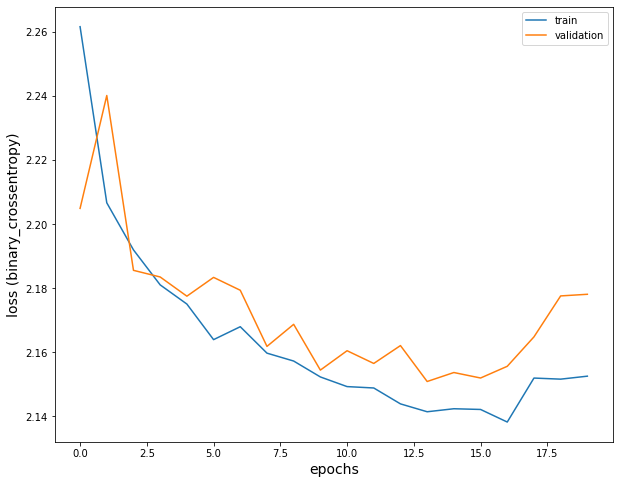

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.xlabel('epochs', fontsize=14)
plt.ylabel('loss (binary_crossentropy)', fontsize=14)
plt.legend()

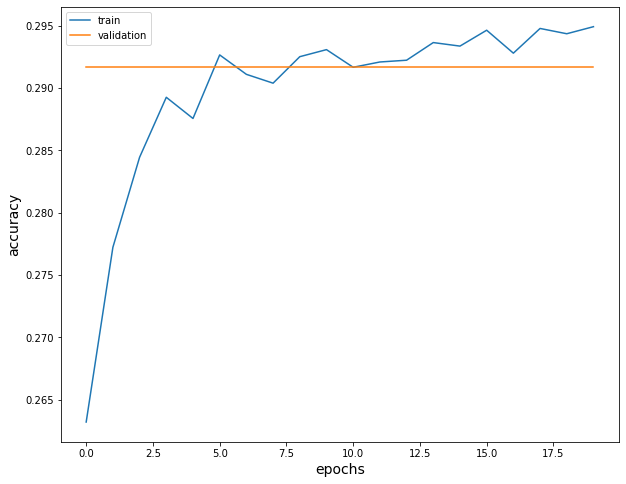

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')

plt.xlabel('epochs', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.legend()

In [ ]:

## Call Backs
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model_teste01.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0001)
]

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, np.expand_dims(y_data, axis=-1), 
                                                    test_size=0.2, random_state=666)
BATCH = 8
EPOCAS = 100

loss = np.zeros((EPOCAS))
val_loss =np.zeros((EPOCAS))
accuracy =np.zeros((EPOCAS))
val_accuracy = np.zeros((EPOCAS))
ims= []

results = model.fit(x_train, y_train, batch_size=BATCH, epochs=EPOCAS, callbacks=callbacks, validation_data=(x_val, y_val))





###feito pelo marco -- rede e tratamento de dados


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre
import tensorflow as tf
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Masking, LSTM
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K



In [ ]:
def normalize_table(tab):
  f_scaler=pre.MinMaxScaler(feature_range=(-1,1)).fit(tab[:,1:3])
  #e_scaler=pre.MinMaxScaler(feature_range=(-1,1)).fit(tab[:,2])
  tab[:,1:3]=f_scaler.transform(tab[:,1:3])
  #tab[:,2]=e_scaler.transform(tab[:,2])
  tab[:,0]=tab[:,0]-np.min(tab[:,0])

  return tab

In [ ]:
obj_ids=metadata_train['object_id']
tables=[]
for i in range(len(obj_ids)):
  lines=lightcurves_train[lightcurves_train['object_id']==obj_ids[i]]
  flux=np.array(lines['flux'].values)
  error=np.array(lines['flux_err'].values)
  id = np.array(lines['object_id'].values)
  mjd=np.array(lines['mjd'].values)
  filter=np.array(lines['passband'].values)
  table=np.array([mjd,flux,error,filter,id],dtype=np.float32).T
  table=normalize_table(table)
  tables.append(table)

tables=tf.keras.preprocessing.sequence.pad_sequences(tables,value=-99 ,maxlen=352, padding='post')

np_tables=np.array(tables)
print(np_tables)

[[[        0         0         0         2       615]
  [        0         0         0         1       615]
  [        0         0         0         3       615]
  ...
  [      873         0         0         3       615]
  [      873         0         0         4       615]
  [      873         0         0         5       615]]

 [[        0         0         0         2       713]
  [        0         0         0         1       713]
  [        0         0         0         3       713]
  ...
  [      848         0         0         0       713]
  [      -99       -99       -99       -99       -99]
  [      -99       -99       -99       -99       -99]]

 [[        0         0         0         2       730]
  [        0         0         0         1       730]
  [        0         0         0         3       730]
  ...
  [      -99       -99       -99       -99       -99]
  [      -99       -99       -99       -99       -99]
  [      -99       -99       -99       -99       -99]]

 ...

In [ ]:
y = metadata_train['target'].values
y = pre.LabelBinarizer().fit_transform(y)

x_train, x_valid, y_train, y_valid = train_test_split(np_tables, y, test_size=0.1, random_state=42)

In [ ]:
model = Sequential()
model.add(Masking(mask_value=-99, input_shape=(352, 5)))
model.add(LSTM(32, activation='relu'))
#model.add(LSTM(64, activation='relu'))

model.add(Dense(14, activation='Softmax'))
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics = ['accuracy'])
# fit model
EPOCHS = 2
BATCH_SIZE = 64

history = model.fit(x=x_train,
                    y=y_train,
                        validation_data=(x_valid, y_valid),
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE)

Epoch 1/2
111/111 [==============================] - 38s 298ms/step - loss: 27926944434626756608.0000 - accuracy: 0.1048 - val_loss: 47377316.0000 - val_accuracy: 0.0191
Epoch 2/2
111/111 [==============================] - 28s 257ms/step - loss: 867932694892249088.0000 - accuracy: 0.0641 - val_loss: 6374036.0000 - val_accuracy: 0.0471


In [ ]:
import tensorflow.keras as tfk

model = Sequential()
model.add(LSTM(128, activation='Relu', input_shape=(352, 5)))
model.add(Dropout(0.2))
#model.add(LSTM(128, activation='tanh'))
#model.add(Dropout(0.2))
#model.add(Dense(32, activation='tanh'))
#model.add(Dropout(0.2))

model.add(Dense(14, activation='Softmax'))
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics = ['accuracy'])
# fit model
EPOCHS = 20
BATCH_SIZE = 64





callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model_teste01.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.40,
                              patience=10, min_lr=0.0001)
]









history = model.fit(x=x_train,
                    y=y_train,
                        validation_data=(x_valid, y_valid),
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        batch_size=BATCH_SIZE)


Epoch 1/20
111/111 [==============================] - ETA: 0s - loss: 2.2504 - accuracy: 0.2706
Epoch 1: val_loss improved from inf to 2.19267, saving model to model_teste01.h5
111/111 [==============================] - 87s 754ms/step - loss: 2.2504 - accuracy: 0.2706 - val_loss: 2.1927 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 2/20
111/111 [==============================] - ETA: 0s - loss: 2.1920 - accuracy: 0.2884
Epoch 2: val_loss improved from 2.19267 to 2.19223, saving model to model_teste01.h5
111/111 [==============================] - 72s 643ms/step - loss: 2.1920 - accuracy: 0.2884 - val_loss: 2.1922 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 3/20
 72/111 [==================>...........] - ETA: 25s - loss: 2.1890 - accuracy: 0.2821

KeyboardInterrupt: ignored

###Marco_novos dadodos e tratamento

In [ ]:
def normalize_table(tab):
  f_scaler=pre.MinMaxScaler(feature_range=(-1,1)).fit(tab[:,1:3])
  tab[:,1:3]=f_scaler.transform(tab[:,1:3])
  tab[:,0]=tab[:,0]-np.min(tab[:,0])

  return tab

In [ ]:

def trata_dados(metadads):
  tables=[]


  for i in range(len(obj_ids)):
    lines= lightcurves_train[lightcurves_train['object_id'] == obj_ids[i]]
    flux=np.array(lines['flux'])
    error=np.array(lines['flux_err'])
    mjd=np.array(lines['mjd'])
    filter=np.array(lines['passband'])
    table=np.array([mjd,flux,error,filter],dtype=np.float32).T
    table=normalize_table(table)
    tables.append(table)

  tables=tf.keras.preprocessing.sequence.pad_sequences(tables,value=-99 ,maxlen=352, padding='post')

  return(tables)

tables_train = trata_dados(metadata_test, lightcurves_extra)


print(tables_train)

[ 5.71036438e+02  7.49963562e+02  8.11698425e+02  7.91284973e+02
  8.34375305e+02  7.59056091e+02  2.14849390e+03  2.28512256e+03
  2.47102197e+03  2.61835791e+03  2.26977856e+03  4.46383203e+03
  4.96022266e+03  4.97290186e+03  4.99514404e+03  4.53169189e+03
  4.90862451e+03  3.08828394e+03  5.03067139e+03  3.32093628e+03
  1.03660071e+03  1.08198230e+03  1.21493486e+04  1.00438887e+04
  1.63663906e+04  2.73438184e+04  2.90582129e+04  3.14370898e+04
  5.49828750e+04  7.76132178e+03  3.04264795e+03  2.32277393e+03
  2.26248633e+03  1.99136682e+03  1.49787781e+03  1.64921436e+03
  8.48485596e+02  1.47504224e+03  1.24245044e+03  1.10311218e+03
  1.28821643e+03  1.21118420e+03  1.24417993e+03  8.60472778e+02
  8.39401184e+02  1.29561722e+02  4.41659821e+02  6.69308594e+02
  6.85887634e+02  3.98940002e+02  7.35358200e+01  3.48590912e+02
  3.68633392e+02  3.94234711e+02  3.04545258e+02  3.05615570e+02
  2.70237976e+02  9.07141110e+01  2.76659332e+02  1.00993713e+02
  1.95757477e+02  2.01932

In [ ]:
obj_ids = metadata_test['object_id']
obj_ids()

TypeError: ignored

In [ ]:
import sklearn.preprocessing as pre

def normalize_table(tab):
  f_scaler=pre.MinMaxScaler(feature_range=(0,1)).fit(tab[:,1:3])
  #e_scaler=pre.MinMaxScaler(feature_range=(-1,1)).fit(tab[:,2])
  tab[:,1:3]=f_scaler.transform(tab[:,1:3])
  #tab[:,2]=e_scaler.transform(tab[:,2])
  tab[:,0]=tab[:,0]-np.min(tab[:,0])

  return tab

def pre_process(data_df,metadata_df,index):

  if index == 1:
    data_df = data_df.merge(metadata_df[['object_id', 'target']], how= 'inner', on = 'object_id')
  if index == 0:
    data_df = data_df.merge(metadata_df[['object_id', 'true_target']], how= 'inner', on = 'object_id')
  
  
  
  if 'true_target' in data_df.columns:
   data_df = data_df.rename(columns = {'true_target': 'target'}, inplace = False)


  obj_ids_def = data_df[data_df['target'] //99 != 10]
  obj_ids = obj_ids_def['object_id'].unique()
  print(obj_ids)
  tables = np.empty(1)


  for i in range(len(obj_ids)):
      lines = data_df[data_df['object_id'] == obj_ids[i]]
      table = lines[['mjd', 'flux', 'flux_err', 'passband']].values
      table = normalize_table(table)
      tables=np.append(tables,table)
      

      y = metadata_df['target'].values
      y = pre.LabelBinarizer().fit_transform(y)

  return lightcurves_test, lightcurves_train


[104854439 104855072 104856301 ... 117791228 117791254 117792193]
(142, 4)
(140, 4)
(142, 4)
(153, 4)
(131, 4)
(105, 4)
(130, 4)
(113, 4)
(110, 4)
(140, 4)
(132, 4)
(120, 4)
(130, 4)
(123, 4)
(136, 4)
(125, 4)
(123, 4)
(114, 4)
(122, 4)
(131, 4)
(144, 4)
(122, 4)
(107, 4)
(138, 4)
(142, 4)
(153, 4)
(119, 4)
(136, 4)
(129, 4)
(144, 4)
(129, 4)
(127, 4)
(135, 4)
(150, 4)
(109, 4)
(128, 4)
(110, 4)
(134, 4)
(105, 4)
(117, 4)
(132, 4)
(133, 4)
(109, 4)
(125, 4)
(128, 4)
(144, 4)
(133, 4)
(130, 4)
(132, 4)
(116, 4)
(118, 4)
(119, 4)
(112, 4)
(115, 4)
(110, 4)
(149, 4)
(138, 4)
(137, 4)
(135, 4)
(115, 4)
(145, 4)
(116, 4)
(118, 4)
(119, 4)
(142, 4)
(88, 4)
(124, 4)
(144, 4)
(138, 4)
(106, 4)
(109, 4)
(142, 4)
(145, 4)
(136, 4)
(103, 4)
(131, 4)
(116, 4)
(142, 4)
(126, 4)
(117, 4)
(149, 4)
(139, 4)
(110, 4)
(100, 4)
(118, 4)
(146, 4)
(114, 4)
(128, 4)
(67, 4)
(140, 4)
(141, 4)
(108, 4)
(136, 4)
(139, 4)
(122, 4)


KeyboardInterrupt: ignored

In [ ]:
x_test,y_test = pre_process(lightcurves_extra,metadata_test,0)
x_train,y_train = pre_process(lightcurves_train,metadata_train,1)

In [ ]:
x_test,y_test = pre_process(lightcurves_extra,metadata_test)
x_train,y_train = pre_process(lightcurves_train,metadata_train)

In [ ]:
metadata_test
lightcurves_test = lightcurves_extra.merge(metadata_test[['object_id', 'true_target']], how= 'inner', on = 'object_id')

lightcurves_test

,Unnamed: 0,object_id,mjd,passband,flux,flux_err,detected_bool,true_target
0,1726,104854439,59782.3010,5,-54.950680,20.642714,0,90
1,1727,104854439,59782.3728,3,-1.078909,6.929646,0,90
2,1728,104854439,59783.3291,2,-2.628200,2.834802,0,90
3,1729,104854439,59784.3163,2,3.851461,3.803087,0,90
4,1730,104854439,59785.4407,4,-10.093822,23.004559,0,90
...,...,...,...,...,...,...,...,...
2559957,44280421,117792193,60522.0112,2,-0.497357,4.704787,0,90
2559958,44280422,117792193,60531.0332,2,-4.563580,4.376515,0,90
2559959,44280423,117792193,60538.9917,5,-12.113405,20.099659,0,90
2559960,44280424,117792193,60544.0012,3,-5.898130,3.738762,0,90


In [ ]:
lightcurves_test['object_id'].nunique()

#set intersection

20000

In [ ]:
set_test = set(lightcurves_test['object_id'].values)
set2_test = set(metadata_test['object_id'].values)


set_test in set2_test

False

In [ ]:
set_test = (lightcurves_test['object_id'].unique())
set2_test = (metadata_test['object_id'].unique())

print(set_test.shape)
print(set2_test.shape)


(20000,)
(3492890,)


In [ ]:
set_test in set2_test

for s in set_test:
  assert s in set(set2_test), f'{s}'

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, GlobalMaxPool1D
from tensorflow.keras.layers import Dense, Masking, Bidirectional, Conv1D,MaxPool1D
import keras


model = Sequential()
#model.add(Masking(mask_value=-99, input_shape=(352, 4)))

model.add(Conv1D(filters=32,kernel_size=2,activation='tanh',input_shape=(352, 4)))
model.add(MaxPool1D())
model.add(Conv1D(filters=64,kernel_size=2,activation='tanh'))
model.add(MaxPool1D())

model.add(Bidirectional(LSTM(200, activation='tanh', return_sequences=True),merge_mode='concat'))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256, activation='tanh', return_sequences=True),merge_mode='concat'))

model.add(GlobalMaxPool1D())
#model.add(Dropout(0.2))

model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(14, activation='Softmax'))

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])
# fit model
EPOCHS = 20
BATCH_SIZE = 64





callbacks = [
    EarlyStopping(patience=10, verbose=1,restore_best_weights=True),
    #ModelCheckpoint('model_teste01.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.20,
                              patience=5, min_lr=0.00001)
]






# fit model
EPOCHS = 50
BATCH_SIZE = 64

history = model.fit(x=x_train,
                    y=y_train,
                        validation_data=(x_valid, y_valid),
                        epochs=EPOCHS,
                      callbacks=callbacks,
                        batch_size=BATCH_SIZE)
     